In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dirac_delta(x,y):
    """Dirac delta function delta(x,y)=1 iff x=y else 0"""
    if x == y: return 1
    else:return 0

def energy(system, i, j):
    """Energy function of spins connected to site (i, j)."""
    L = system.shape[0]
    assert L == system.shape[1], "Need to be square lattice!"
    e_ij = dirac_delta(system[i,j],system[np.mod(i-1,L),j])+\
    dirac_delta(system[i,j],system[np.mod(i+1,L),j])+\
    dirac_delta(system[i,j],system[i,np.mod(j-1,L)])+\
    dirac_delta(system[i,j],system[i,np.mod(j+1,L)])
    return -2*e_ij

def calc_theta(m):
    """Calculate the cutting angle between m and real axis"""
    if m.imag >= 0: theta=np.arccos(m.real/abs(m))
    elif m.real >=0: theta=np.arcsin(m.imag/abs(m))
    else: theta=np.arctan(m.imag/m.real)-np.pi
    return theta

def measure_magnetization(system,N):
    """Measure total magnetization of the system.
    Returns m (complex)"""
    L = system.shape[0]
    quant=2*np.pi/N
    m = 0
    for i in range(L):
        for j in range(L):
            m += np.exp(1j*quant*system[i,j])
    return m

def measure_energy(system):
    """Measure total energy of the system"""
    L = system.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            E += energy(system, i, j) / 2.
    return E

def prepare_system(N,L):
    """Initialize the system."""
    system = np.random.randint(0, N, size=(L, L))
    return system

def metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips):
    """ Main loop doing the Metropolis algorithm."""
    E = measure_energy(system)
    M = measure_magnetization(system,N)
    quant=2*np.pi/N
    L = system.shape[0]
    E_list, M_list = [E], [M]
    for step in range(N_sweeps + N_eq):
        #Choose site (i,j) randomly'
        i,j = np.random.randint(0, L), np.random.randint(0,L)
        #Take the value of spin at site (i,j)'
        old_val=system[i,j]
        #Flip the spin at site (i,j)'
        new_val=np.random.choice(list(range(old_val))+list(range(old_val+1,N)))
        
        #Calculate the change of energy
        dE = -2*(dirac_delta(new_val,system[np.mod(i-1,L),j])+\
             dirac_delta(new_val,system[np.mod(i+1,L),j])+\
             dirac_delta(new_val,system[i,np.mod(j-1,L)])+\
             dirac_delta(new_val,system[i,np.mod(j+1,L)]))-energy(system, i, j)
        #Calculate the change of magnetization
        dM = np.exp(1j*quant*new_val)-np.exp(1j*quant*old_val)
        if dE <= 0.:
            system[i,j] = new_val
            E += dE
            M += dM
        elif np.exp(-1. / T * dE) > np.random.rand():
            system[i,j] = new_val
            E += dE
            M += dM
        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E_list.append(E)
            M_list.append(M)
    return system, np.array(E_list), np.array(M_list)

In [2]:
def spec_heat(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate specific heat for a given N-state potts model with temperature T"""
    L=system.shape[0]
    c_bin = []
    for k in range(N_bins):    
        Es = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[1]

        c_bin.append(1. / T**2. / L**2. * np.var(Es))
        
    return np.mean(c_bin), np.std(c_bin)/np.sqrt(N_bins)

def abs_magnetization(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate |m|=|M/(Lx*Ly)| for a given N-state potts model with temperature T"""
    L=system.shape[0]
    abs_m_bin = []
    for k in range(N_bins):
        Ms = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[2]
        
        mean_abs_m = np.mean(np.abs(Ms))/L**(2)
        
        abs_m_bin.append(mean_abs_m)
        
    return np.mean(abs_m_bin), np.std(abs_m_bin)/np.sqrt(N_bins)

def energy_density(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate e=E/(Lx*Ly) for a given N-state potts model with temperature T"""
    L=system.shape[0]
    e_bin = []
    for k in range(N_bins):
        Es = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[1]
        
        mean_e = np.mean(Es/L**(2))
        
        e_bin.append(mean_e)
        
    return np.mean(e_bin), np.std(e_bin)/np.sqrt(N_bins)

def magn_susceptibility(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate magnetic susceptibility for a given N-state potts model with temperature T"""
    L=system.shape[0]
    chi_bin = []
    for k in range(N_bins):
        Ms = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[2]
        
        chi_bin.append(1. / T / L**2. * np.var(np.abs(Ms)))
        
    return np.mean(chi_bin), np.std(chi_bin)/np.sqrt(N_bins)

def Binder_e_cumulant(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate Binder cumulant with order parameter e"""
    L=system.shape[0]
    UBe_bin=[]
    for k in range(N_bins):
        Es = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[1]
        
        mean_e4 = np.mean((Es/L**(2))**4)
        mean_e2 = np.mean((Es/L**(2))**2)
        
        UBe_bin.append(3/2*(1 - 1/3 * mean_e4 / mean_e2**2))
    
    return np.mean(UBe_bin), np.std(UBe_bin)/np.sqrt(N_bins)

def Binder_m_cumulant(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Calculate Binder cumulant with order parameter |m|"""
    L=system.shape[0]
    UBm_bin=[]
    for k in range(N_bins):
        Ms = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)[2]
        
        mean_m4 = np.mean(np.abs(Ms/L**(2))**4)
        mean_m2 = np.mean(np.abs(Ms/L**(2))**4)
        
        UBm_bin.append(3/2*(1 - 1/3 * mean_m4 / mean_m2**2))
    
    return np.mean(UBm_bin), np.std(UBm_bin)/np.sqrt(N_bins)
    
def produce_result(system,N,T,N_sweeps,N_eq,N_flips,N_bins):
    """Run metropolis algorithm to measure e, cv, m, |m|, chi, UBe, and UBm"""
    #Take system size
    L=system.shape[0]
    
    #Prepare list of measurement results
    e_bin = [] #for energy density
    c_bin = [] #for specific heat
    m_bin = [] #for (complex) magnetization
    abs_m_bin = [] #for |m|
    chi_bin = [] #for magnetic susceptibility
    UBe_bin = [] #for Binder cumulant calculated using e
    UBm_bin = [] #for Binder cumulant calculated using |m|
    
    #Fill list of measurement results
    for k in range(N_bins):
        system, Es, Ms = metropolis_loop(system, N, T, N_sweeps, N_eq, N_flips)
        
        mean_e4 = np.mean((Es/L**(2))**4) # <(E/N)^4>=<e^4>
        mean_e2 = np.mean((Es/L**(2))**2) # <(E/N)^2>=<e^2>
        mean_abs_m4 = np.mean((np.abs(Ms)/L**(2))**4) # <|m|^4>
        mean_abs_m2 = np.mean((np.abs(Ms)/L**(2))**2) # <|m|^2>
        
        e_bin.append(np.mean(Es/L**(2))) #fill energy density list
        c_bin.append(np.var(Es) / (L**(2) * T**(2))) #fill specific hear list
        m_bin.append(np.mean(Ms)/L**(2)) #fill (complex) magnetization
        abs_m_bin.append(np.mean(np.abs(Ms))/L**(2)) #fill <|m|>
        chi_bin.append(np.var(np.abs(Ms))/(L**(2) * T)) #fill magnetic susceptibility
        UBe_bin.append(3/2*(1 - 1/3*mean_e4/mean_e2**2)) #fill Binder cumulant UBe
        UBm_bin.append(3/2*(1 - 1/3*mean_abs_m4/mean_abs_m2**2)) #fill Binder cumulant UBm
        
    return np.mean(e_bin), np.std(e_bin)/np.sqrt(N_bins),\
           np.mean(c_bin), np.std(c_bin)/np.sqrt(N_bins),\
           np.mean(m_bin),\
           np.mean(abs_m_bin), np.std(abs_m_bin)/np.sqrt(N_bins),\
           np.mean(chi_bin), np.std(chi_bin)/np.sqrt(N_bins),\
           np.mean(UBe_bin), np.std(UBe_bin)/np.sqrt(N_bins),\
           np.mean(UBm_bin), np.std(UBm_bin)/np.sqrt(N_bins)

In [3]:
print("Produce data...")
Ns = [2,4,6]
Ls = [8,16,32]

data_ferro=dict((N, dict((L, []) for L in Ls)) for N in Ns)

for N in Ns:
    Tc_guess = 2/np.log(1+np.sqrt(N))
    for L in Ls:
        print("Start N={N}, L={L}".format(N=N,L=L))
        Ts = np.linspace(Tc_guess - 0.5, Tc_guess + 0.5, 25)
        Ts = np.append(Ts, np.linspace(Tc_guess - 8./L, Tc_guess + 8./L, 50))
        Ts = np.sort(Ts)[::-1]
        data_ferro[N][L].append(Ts) # fill data_ferro {N:{L:[Ts]},...}
        init_system = prepare_system(N,L) # initiate system
        
        # prepare list of measurement results
        e_list = np.array([])
        c_list = np.array([])
        m_list = np.array([])
        abs_m_list = np.array([])
        chi_list = np.array([])
        UBe_list = np.array([])
        UBm_list = np.array([])
        
        #set parameters for metropolis loop
        N_sweeps = int(500 * L**2)
        N_eq = int(N_sweeps // 5)
        N_flips = 10
        N_bins = 5
        
        # measure above units for each T using for-loop
        for T in Ts:
            e, e_err, \
            c, c_err, \
            m, \
            abs_m, abs_m_err, \
            chi, chi_err, \
            UBe, UBe_err, \
            UBm, UBm_err = produce_result(init_system,N,T,N_sweeps,N_eq,N_flips,N_bins)
            
            e_list = np.append(e_list, [e, e_err])
            c_list = np.append(c_list, [c, c_err])
            m_list = np.append(m_list, m)
            abs_m_list = np.append(abs_m_list, [abs_m, abs_m_err])
            chi_list = np.append(chi_list, [chi, chi_err])
            UBe_list = np.append(UBe_list, [UBe, UBe_err])
            UBm_list = np.append(UBm_list, [UBm, UBm_err])
            
        data_ferro[N][L].append(e_list) # fill data_ferro {N:{L:[Ts, e_list]},...}
        data_ferro[N][L].append(c_list) # fill data_ferro {N:{L:[Ts, e_list, c_list]}}
        data_ferro[N][L].append(m_list) # fill data_ferro {N:{L:[Ts, e_list, c_list, m_list]}}
        data_ferro[N][L].append(abs_m_list) # fill data_ferro {N:{L:[Ts, e_list, c_list, m_list, abs_m_list]}}
        data_ferro[N][L].append(chi_list) # fill data_ferro {N:{L:[Ts, e_list, c_list, m_list, abs_m_list, chi_list]}}
        data_ferro[N][L].append(UBe_list) # fill data_ferro {N:{L:[Ts, e_list, c_list, m_list, abs_m_list, chi_list, UBe_list]}}
        data_ferro[N][L].append(UBm_list) # fill data_ferro {N:{L:[Ts, e_list, c_list, m_list, abs_m_list, chi_list, UBe_list, UBm_list]}}
        
        print("Finish N={N}, L={L}".format(N=N,L=L))
    
    data_ferro[N]['2Tc/J']=Tc_guess # fill data_ferro {N:{'2Tc/J':Tc_guess}}

print("...Production of data finished")

'''Info:
c_list=[c1,c_err1,c2,c_err2]
cs=c_list[::2] --> [c1,c2,c3,...]
c_errs=c_list[1::2] --> [c_err1,c_err2,c_err3,...]
ms=m_list'''

Produce data...
Start N=2, L=8
Finish N=2, L=8
Start N=2, L=16
Finish N=2, L=16
Start N=2, L=32
Finish N=2, L=32
Start N=4, L=8
Finish N=4, L=8
Start N=4, L=16
Finish N=4, L=16
Start N=4, L=32
Finish N=4, L=32
Start N=6, L=8
Finish N=6, L=8
Start N=6, L=16
Finish N=6, L=16
Start N=6, L=32
Finish N=6, L=32
...Production of data finished


In [6]:
import pickle
print("Save data...")
filename='data_ferro.pkl'  
with open(filename, 'wb') as f:
    pickle.dump(data_ferro, f)
print("...Done")

Save data...
...Done


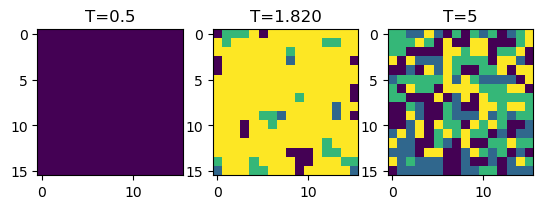

In [34]:
T=[0.5,1.820478,5]
N=4
L=16
system1=prepare_system(N,L)
system2=prepare_system(N,L)
system3=prepare_system(N,L)

N_sweeps=int(500*L**(2))
N_eq=int(500*L**(2)*3/20)
N_flips=100

metropolis_loop(system1, N, 0.5, N_sweeps, N_eq, N_flips)
metropolis_loop(system2, N, 2/np.log(1+np.sqrt(4)), N_sweeps, N_eq, N_flips)
metropolis_loop(system3, N, 5, N_sweeps, N_eq, N_flips)



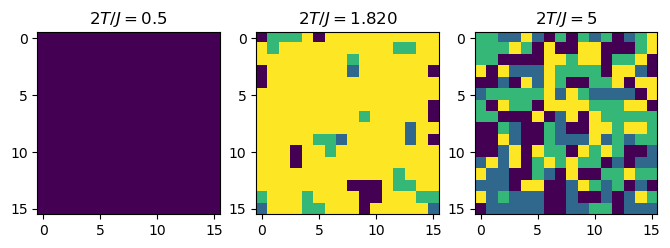

In [46]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(system1)
plt.title("$2T/J={T}$".format(T=0.5))

plt.subplot(132)
plt.imshow(system2)
plt.title("$2T/J={T:.3f}$".format(T=2/np.log(1+np.sqrt(4))))

plt.subplot(133)
plt.imshow(system3)
plt.title("$2T/J={T}$".format(T=5))
plt.savefig('Lattice_after.pdf',dpi=1200)
plt.show()
